In [1]:
import pandas as pd
import geopandas as gpd
import folium
import re
import numpy as np

In [6]:
# read data
service_requests = pd.read_csv('311_Service_Requests_from_2010_to_Present_20241030.csv')
service_requests

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,62900248,10/29/2024 01:31:21 AM,NaN,DSNY,Department of Sanitation,Dirty Condition,Trash,Sidewalk,10304.0,107 JEFFERSON STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.589356,-74.098797,"(40.58935556020951, -74.0987970975816)"
1,62905132,10/29/2024 01:29:53 AM,NaN,DSNY,Department of Sanitation,Illegal Dumping,Removal Request,Sidewalk,11216.0,HERKIMER COURT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.679436,-73.945916,"(40.67943630625516, -73.94591629206633)"
2,62908431,10/29/2024 01:21:39 AM,NaN,DSNY,Department of Sanitation,Illegal Dumping,Removal Request,Sidewalk,11106.0,33-19 36 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.755739,-73.927922,"(40.75573902415911, -73.92792248943132)"
3,62900208,10/29/2024 12:32:21 AM,NaN,DSNY,Department of Sanitation,Dirty Condition,Trash,Sidewalk,11238.0,571 CLASSON AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.681215,-73.958469,"(40.68121464543949, -73.95846898014925)"
4,62906798,10/28/2024 11:49:16 PM,NaN,DSNY,Department of Sanitation,Dirty Condition,Trash,Sidewalk,11365.0,195-60 PECK AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.741678,-73.779302,"(40.74167815705963, -73.7793020085076)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259175,51937180,09/21/2021 08:21:29 PM,09/21/2021 10:55:10 PM,DSNY,Department of Sanitation,Dirty Condition,Debris from Car Accident,Street,10038.0,375 PEARL STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.710303,-74.001053,"(40.71030295032086, -74.00105324675815)"
259176,55208756,05/04/2021 03:50:33 PM,05/06/2021 10:18:29 AM,DSNY,Department of Sanitation,Dirty Condition,Dog Waste,Sidewalk,11436.0,145 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.684859,-73.798982,"(40.684859049707526, -73.79898217069032)"
259177,51952779,06/13/2019 08:51:00 AM,NaN,DSNY,Department of Sanitation,Dirty Condition,Dog Waste,Sidewalk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259178,51949799,06/12/2019 05:16:00 PM,NaN,DSNY,Department of Sanitation,Dirty Condition,Poster or Sign,Sidewalk,11212.0,1737 EAST NEW YORK AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.675273,-73.904176,"(40.67527273859748, -73.9041760277674)"


In [7]:
# drop unnecessary rows
service_requests = service_requests.drop(['Vehicle Type', 'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
                       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment', 'Closed Date'], axis = 1)

In [8]:
#sort trash by zip code
trash_in_zip_code = pd.DataFrame(service_requests.groupby('Incident Zip').size().sort_values(ascending=False)).reset_index()
trash_in_zip_code = trash_in_zip_code.rename(columns={0: 'Service Calls'})
trash_in_zip_code

,Incident Zip,Service Calls
0,11207.0,5143
1,11385.0,4137
2,11220.0,4045
3,10312.0,3978
4,11208.0,3888
...,...,...
209,10176.0,1
210,10179.0,1
211,11050.0,1
212,11241.0,1


In [9]:
# load another dataset on population density
nyc_population_neighborhood = pd.read_csv('9ff6db90-ee94-4113-a0ed-40b4b9ab75cd.csv')
nyc_population_neighborhood

FileNotFoundError: [Errno 2] No such file or directory: '9ff6db90-ee94-4113-a0ed-40b4b9ab75cd.csv'

In [10]:
#merge two datasets
nyc_population_neighborhood_copy = nyc_population_neighborhood.drop(['_id', 'post_office', 'borough'], axis=1)
service_request_neighborhood = service_requests.merge(nyc_population_neighborhood_copy, left_on = 'Incident Zip',
                                                      right_on = 'zip')
map_data = service_request_neighborhood.groupby('neighborhood').size().reset_index()
map_data
service_request_neighborhood

NameError: name 'nyc_population_neighborhood' is not defined

In [7]:
zip_spatial_data = pd.read_csv('Modified_Zip_Code_Tabulation_Areas__MODZCTA_.csv')
zip_spatial_neighborhood = zip_spatial_data.merge(trash_in_zip_code, left_on = 'MODZCTA', right_on='Incident Zip')
zip_spatial_neighborhood

,MODZCTA,label,ZCTA,pop_est,the_geom,Incident Zip,Service Calls
0,10001,"10001, 10118","10001, 10119, 10199",23072,MULTIPOLYGON (((-73.98774438827894 40.74406551...,10001.0,1151
1,10002,10002,10002,74993,MULTIPOLYGON (((-73.99750380833868 40.71407144...,10002.0,1947
2,10003,10003,10003,54682,MULTIPOLYGON (((-73.98863576728334 40.72293099...,10003.0,2482
3,10026,10026,10026,39363,MULTIPOLYGON (((-73.96200720826798 40.80550908...,10026.0,1628
4,10004,10004,10004,3028,MULTIPOLYGON (((-74.00826694529984 40.70771979...,10004.0,97
...,...,...,...,...,...,...,...
172,11433,11433,"11433, 11451",36489,MULTIPOLYGON (((-73.79437143341872 40.68691219...,11433.0,2154
173,11434,11434,"11430, 11434",65989,MULTIPOLYGON (((-73.75460907012868 40.64719952...,11434.0,2032
174,11435,11435,11435,59296,MULTIPOLYGON (((-73.8057700022681 40.682930109...,11435.0,2128
175,11694,11694,11694,21354,MULTIPOLYGON (((-73.86495602260939 40.56663006...,11694.0,289


<h1>Route Optimization</h1>
In the previous section, I have these datasets: trash_in_zip_code, nyc_population_neighborhood, Now I want to start finding the optimal route in NYC for trash cleanups. 
______________________________________________________________________________________________________________________________

In [8]:
#Turn neighborhood data into spatial data
df = pd.read_csv('Modified_Zip_Code_Tabulation_Areas__MODZCTA_.csv')

gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['the_geom']))

gdf.head()

gdf['centroid'] = gdf.geometry.centroid
gdf['latitude'] = gdf['centroid'].y
gdf['longitude'] = gdf['centroid'].x

gdf[['MODZCTA', 'latitude', 'longitude']].head()



,MODZCTA,latitude,longitude
0,10001,40.750688,-73.997138
1,10002,40.715780,-73.986174
2,10003,40.731826,-73.989159
3,10026,40.802382,-73.952672
4,10004,40.703747,-74.013032


Now we have a bunch of neighborhoods, we want to focus on one neighborhood with the highest density of trash, then try to see if we can find trash data by street in that particular neighborhood.

In [9]:
#neighborhood with the most trash: Borough Park 
borough_park = service_request_neighborhood[service_request_neighborhood['neighborhood'] == 'Borough Park']
bp_street_data = pd.DataFrame(borough_park.groupby('Street Name').size().sort_values(ascending = False).reset_index())
bp_street_data = bp_street_data.rename(columns={0: 'Service Calls Count'})
number_words = {
    "FIRST": 1, "SECOND": 2, "THIRD": 3, "FOURTH": 4, "FIFTH": 5, "SIXTH": 6, "SEVENTH": 7, "EIGHTH": 8,
    "NINTH": 9, "TENTH": 10, "ELEVENTH": 11, "TWELFTH": 12, "THIRTEENTH": 13, "FOURTEENTH": 14, "FIFTEENTH": 15,
    "SIXTEENTH": 16, "SEVENTEENTH": 17, "EIGHTEENTH": 18, "NINETEENTH": 19, "TWENTIETH": 20
}

def add_ordinal_suffix(street_name):
    # First, replace number words with their numeric equivalents
    words = street_name.split()
    for i, word in enumerate(words):
        if word.upper() in number_words:
            number = number_words[word.upper()]
            words[i] = str(number)
    
    # Rebuild the street name after converting words to numbers
    street_name = " ".join(words)
    
    # This regex will match numbers and add ordinal suffix
    match = re.match(r"^(EAST|WEST|NORTH|SOUTH)?\s*(\d+)\s*(.+)", street_name, re.IGNORECASE)
    if match:
        prefix = match.group(1) if match.group(1) else ""
        number = int(match.group(2))
        suffix = "th" if 11 <= number % 100 <= 13 else {1: "st", 2: "nd", 3: "rd"}.get(number % 10, "th")
        formatted_name = f"{prefix} {number}{suffix} {match.group(3)}".strip()
        return formatted_name
    return street_name

# Apply the function to add ordinal suffixes
bp_street_data['Street Name'] = bp_street_data['Street Name'].apply(add_ordinal_suffix)
bp_street_data.loc[bp_street_data['Street Name'].isin(['FORT HAMILTON PARKWA', 'FORT HAMILTON PKW']), 'Street Name'] = 'FORT HAMILTON PARKWAY'
bp_street_data.loc[bp_street_data['Street Name'].isin(['MC DONALD AVENUE', 'MACDONALD AVENUE', 'MAC DONALD AVENUE']), 'Street Name'] = 'MCDONALD AVENUE'

print(bp_street_data)

             Street Name  Service Calls Count
0          OCEAN PARKWAY                  477
1    CONEY ISLAND AVENUE                  380
2            18th AVENUE                  285
3        MCDONALD AVENUE                  224
4            62nd STREET                  198
..                   ...                  ...
191      WEST 6th STREET                    1
192      WEST 7th STREET                    1
193      WEST 4th STREET                    1
194      WEST 3rd STREET                    1
195     WILLINGTON COURT                    1

[196 rows x 2 columns]


In [10]:
#add street coordinates
!pip install geopy
import geopy
from geopy.geocoders import Nominatim
import pandas as pd
import time

geolocator = Nominatim(user_agent="trash_route_optimizer")

def get_coordinates(street_name):
    try:
        location = geolocator.geocode(street_name + ", Brooklyn, NY")
        return (location.latitude, location.longitude) if location else (None, None)
    except:
        return (None, None)

# Apply geocoding
bp_street_data['Coordinates'] = bp_street_data['Street Name'].apply(get_coordinates)
time.sleep(0.1)  # Add delay to avoid hitting rate limits


# Now, print the entire DataFrame
print(bp_street_data)



             Street Name  Service Calls Count                Coordinates
0          OCEAN PARKWAY                  477    (40.576312, -73.968501)
1    CONEY ISLAND AVENUE                  380  (40.6346762, -73.9674682)
2            18th AVENUE                  285    (40.620671, -73.990414)
3        MCDONALD AVENUE                  224  (40.6391782, -73.9790343)
4            62nd STREET                  198    (40.626472, -73.996895)
..                   ...                  ...                        ...
191      WEST 6th STREET                    1   (40.5776223, -73.974601)
192      WEST 7th STREET                    1  (40.5964721, -73.9785103)
193      WEST 4th STREET                    1  (40.6066917, -73.9774691)
194      WEST 3rd STREET                    1   (40.606216, -73.9764328)
195     WILLINGTON COURT                    1               (None, None)

[196 rows x 3 columns]


In [27]:
bp_street_data = pd.DataFrame(bp_street_data)


# Filter valid rows (remove ones with missing coordinates)
# Make sure you have a unique ID for each row used in the graph
bp_street_data = bp_street_data.dropna(subset=['Coordinates']).reset_index(drop=True)
bp_street_data['node_id'] = bp_street_data.index  # This will align with the graph nodes


# Use Service Calls Count as trash density
trash_density = bp_street_data['Service Calls Count'].astype(int).tolist()
len(trash_density)


192

In [11]:
bp_street_data = bp_street_data[bp_street_data['Coordinates'] != (None, None)]
trash_density_for_nodes = bp_street_data['Service Calls Count']
trash_density_for_nodes

0      477
1      380
2      285
3      224
4      198
      ... 
190      1
191      1
192      1
193      1
194      1
Name: Service Calls Count, Length: 192, dtype: int64

In [ ]:
###debugging purposes only####

from geopy.geocoders import Nominatim

# Initialize geocoder
geolocator = Nominatim(user_agent="trash_route_optimizer")

# Test address
address = "49th RD	, Brooklyn, NY"
location = geolocator.geocode(address)

if location:
    print(f"Address: {address}")
    print(f"Latitude: {location.latitude}, Longitude: {location.longitude}")
else:
    print("Address not found.")


In [12]:
import folium
from folium.plugins import HeatMap
import pandas as pd


map_center = [40.6293, -73.9866]  # Central point for Borough Park, Brooklyn
m = folium.Map(location=map_center, zoom_start=15)


base_radius = 5

max_trash_count = bp_street_data['Service Calls Count'].max()


for idx, row in bp_street_data.iterrows():
    # Scale the radius based on the trash count, ensuring the radius is proportional to the count
    scaled_radius = base_radius + (row['Service Calls Count'] / max_trash_count) * 20  # Adjust 20 to scale the size more or less

    folium.CircleMarker(
        location=row['Coordinates'],
        radius=scaled_radius,  # size of the circle, scaled by trash count
        color='blue',  # marker color
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=f"{row['Street Name']} - Trash Count: {row['Service Calls Count']}"
    ).add_to(m)


# For heatmap, we need the coordinates and weights (trash density)
heat_data = [[coord[0], coord[1], count] for coord, count in zip(bp_street_data['Coordinates'], bp_street_data['Service Calls Count'])]

HeatMap(heat_data).add_to(m)
m


In [13]:
# create nodes and a map that shows the all the nodes

nodes = [
    {"id": idx, "lat": coord[0], "lon": coord[1], "weight": calls_count}
    for idx, (coord, calls_count) in enumerate(zip(bp_street_data['Coordinates'], bp_street_data['Service Calls Count']))
]

map = folium.Map(location=[40.633, -73.969], zoom_start=14)  # Center around Borough Park


for node in nodes:
    folium.CircleMarker(
        location=(node["lat"], node["lon"]),
        radius=5,
        color="blue",
        fill=True,
        fill_color="blue",
        popup=f"ID: {node['id']}, Density: {node['weight']}"
    ).add_to(map)

map


In [14]:
import json

with open('bp_nodes.json', 'w') as f:
    json.dump(nodes, f)

In [2]:
bp_street_data = pd.DataFrame({
"Coordinates": [
    (40.750688, -73.997138),
    (40.715780, -73.986174),
    (40.731826, -73.989159),
    (40.802382, -73.952672),
    (40.703747, -74.013032),
    (40.723547, -74.033052),
]
})

In [81]:
bp_street_data

,Coordinates
0,"(40.750688, -73.997138)"
1,"(40.71578, -73.986174)"
2,"(40.731826, -73.989159)"
3,"(40.802382, -73.952672)"
4,"(40.703747, -74.013032)"
5,"(40.723547, -74.033052)"


In [3]:
# create graph

import networkx as nx
from geopy.distance import geodesic

#bp_street_data = bp_street_data.reset_index()
G = nx.Graph()

# Add nodes (with node_id)
for i, row in bp_street_data.iterrows():
    G.add_node(i, pos=row['Coordinates'])

# Add edges (example: connect based on proximity or street graph — use your logic)
# G.add_edge(i, j, weight=...)

# Now nodes will be [0, 1, 2, ..., 187] — same as row indices
#nodes = list(bp_street_data['node_id'])  # Or just range(len(bp_street_data))



from itertools import combinations

# Connect nodes within a reasonable distance threshold (e.g., 500 meters)
threshold = 7000  # meters
for i, j in combinations(range(len(bp_street_data)), 2):
    coord1 = bp_street_data['Coordinates'].iloc[i]
    coord2 = bp_street_data['Coordinates'].iloc[j]
    distance = geodesic(coord1, coord2).meters
    if distance <= threshold:
        G.add_edge(i, j, weight=distance)



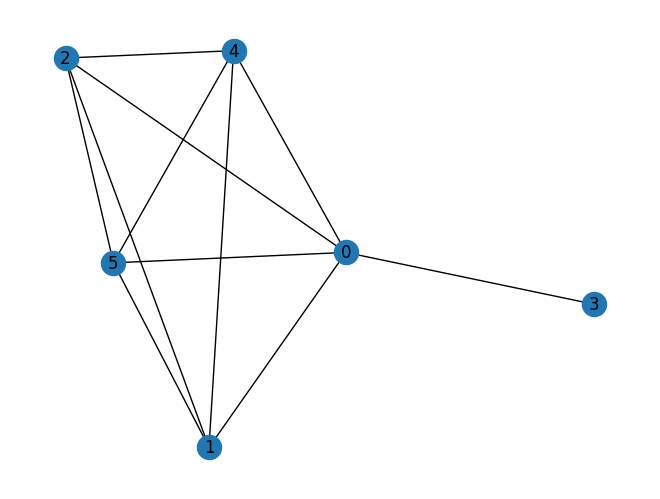

In [4]:
import matplotlib.pyplot as plt
nx.draw(G, with_labels=True)
plt.show()

In [5]:
import numpy as np
import pandas as pd
import networkx as nx

# List of nodes in the graph
nodes = list(G.nodes)

# Initialize distance matrix
distance_matrix = np.zeros((len(nodes), len(nodes)))

# Compute shortest path lengths
for i, node1 in enumerate(nodes):
    for j, node2 in enumerate(nodes):
        if i == j:
            distance_matrix[i][j] = 0  # Distance from node to itself
        else:
            try:
                distance_matrix[i][j] = nx.shortest_path_length(
                    G, source=node1, target=node2, weight='weight')
            except nx.NetworkXNoPath:
                distance_matrix[i][j] = np.inf  # No path between nodes

# Convert to DataFrame for inspection
distance_df = pd.DataFrame(distance_matrix, index=nodes, columns=nodes)

# Check stats
print("Distance Matrix Stats:")
print("Min:", np.min(distance_matrix[distance_matrix != np.inf]))
print("Max:", np.max(distance_matrix[distance_matrix != np.inf]))
print("Mean:", np.mean(distance_matrix[distance_matrix != np.inf]))

print(distance_df)


Distance Matrix Stats:
Min: 0.0
Max: 12241.843985025327
Mean: 4710.014972601388
             0             1            2             3             4  \
0     0.000000   3985.594076  2200.353122   6858.949340   5382.894645   
1  3985.594076      0.000000  1799.642983  10844.543416   2633.736767   
2  2200.353122   1799.642983     0.000000   9059.302462   3713.681780   
3  6858.949340  10844.543416  9059.302462      0.000000  12241.843985   
4  5382.894645   2633.736767  3713.681780  12241.843985      0.000000   
5  4276.307849   4053.577613  3820.375731  11135.257189   2774.208547   

              5  
0   4276.307849  
1   4053.577613  
2   3820.375731  
3  11135.257189  
4   2774.208547  
5      0.000000  


In [75]:
print(bp_street_data['Coordinates'].head())


0    (40.750688, -73.997138)
1    (40.731826, -73.989159)
2    (40.802382, -73.952672)
3    (40.703747, -74.013032)
4    (40.703547, -74.013052)
Name: Coordinates, dtype: object


In [ ]:
"""debugging purposes only

from geopy.distance import geodesic

# Verify distance between two nodes
node1 = 2  # Example node 1 index
node2 = 1  # Example node 2 index

# Get the coordinates for these two nodes from your data
coord1 = bp_street_data['Coordinates'].iloc[node1]
coord2 = bp_street_data['Coordinates'].iloc[node2]

# Compute the geodesic distance
calculated_distance = geodesic(coord1, coord2).meters
print(f"Calculated distance between node {node1} and {node2}: {calculated_distance} meters")

# If you already have the graph with distances as weights, verify with the weight on the edge
print(f"Graph distance between node {node1} and {node2}: {G[node1][node2]['weight']} meters")"""


In [39]:
print("Distance matrix:", len(distance_matrix))
print("Trash density:", len(trash_density))
assert len(distance_matrix) == len(trash_density), "💥 MISMATCH DETECTED"

print("Manager size:", manager.GetNumberOfNodes())


Distance matrix: 192
Trash density: 192
Manager size: 192


In [42]:
distance_matrix

array([[    0.        ,  2200.3531224 ,  6858.94933978,  5382.89464524],
       [ 2200.3531224 ,     0.        ,  9059.30246218,  3713.68178033],
       [ 6858.94933978,  9059.30246218,     0.        , 12241.84398503],
       [ 5382.89464524,  3713.68178033, 12241.84398503,     0.        ]])

In [48]:
routing

<ortools.constraint_solver.pywrapcp.RoutingModel; proxy of <Swig Object of type 'operations_research::RoutingModel *' at 0x17d2adce0> >

In [33]:
print("Distance matrix shape:", len(distance_matrix))
print("Trash density size:", len(trash_density))


Distance matrix shape: 192
Trash density size: 192


In [93]:
import ortools
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

def create_data_model():
    """Stores the data for the problem."""
    data = {
        'distance_matrix': distance_matrix.astype(int), 
        #'trash_density' : trash_density, 
        'num_vehicles': 2,  # Number of trash collectors
        'depot': 0,  # Starting point index
    }
    return data

data = create_data_model()

# Create the routing index manager and model
manager = pywrapcp.RoutingIndexManager(
    len(data['distance_matrix']),
    data['num_vehicles'],
    data['depot']
)
routing = pywrapcp.RoutingModel(manager)

def distance_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)

    # Only use real node indices
    if from_node >= len(data['distance_matrix']) or to_node >= len(data['distance_matrix']):
        return 0

    return data['distance_matrix'][from_node][to_node]




transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


routing.AddDimension(
    transit_callback_index,
    0,       # slack
    1000,    # upper bound per route
    True,    # start at zero
    "Trash"
)

trash_dimension = routing.GetDimensionOrDie("Trash")
# for v in range(data['num_vehicles']):
#     trash_dimension.CumulVar(routing.End(v)).SetMin(500)


# Solve the problem
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
search_parameters.time_limit.seconds = 120
search_parameters.log_search = True
solution = routing.SolveWithParameters(search_parameters)



# Print solution
if solution:
    print(f"Objective: {solution.ObjectiveValue()} miles")
    for vehicle_id in range(data['num_vehicles']):
        print(f'Route for vehicle {vehicle_id}:')
        index = routing.Start(vehicle_id)
        route = []
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        print(route)


I0000 00:00:1752093813.777975 7096349 search.cc:310] Start search (memory used = 124.27 MB)
I0000 00:00:1752093813.778023 7096349 search.cc:310] Root node processed (time = 0 ms, constraints = 50, memory used = 124.27 MB)
I0000 00:00:1752093813.778284 7096349 search.cc:310] Finished search tree (time = 0 ms, branches = 90, failures = 48, memory used = 124.27 MB)
I0000 00:00:1752093813.778295 7096349 search.cc:310] End search (time = 1 ms, branches = 90, failures = 48, memory used = 124.27 MB, speed = 90000 branches/s)


In [ ]:
## Working example

In [95]:
"""Simple Travelling Salesperson Problem (TSP) between cities."""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp



def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = distance_matrix.astype(int)
    data["num_vehicles"] = 2
    data["depot"] = 0
    return data


def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()} miles")
    index = routing.Start(0)
    plan_output = "Route for vehicle 0:\n"
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += f" {manager.IndexToNode(index)} ->"
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += f" {manager.IndexToNode(index)}\n"
    plan_output += f"Route distance: {route_distance}miles\n"
    print(plan_output)



"""Entry point of the program."""
# Instantiate the data problem.
data = create_data_model()

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(
    len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
)

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)


def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data["distance_matrix"][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

# Print solution on console.
# Print solution
if solution:
    print(f"Objective: {solution.ObjectiveValue()} miles")
    for vehicle_id in range(data['num_vehicles']):
        print(f'Route for vehicle {vehicle_id}:')
        index = routing.Start(vehicle_id)
        route = []
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        print(route)

Objective: 27398 miles
Route for vehicle 0:
[0, 3]
Route for vehicle 1:
[0, 2, 1, 4, 5]


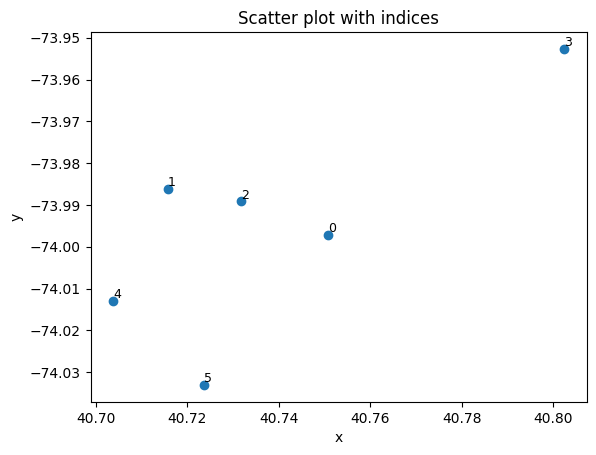

In [9]:
x = bp_street_data['Coordinates'].apply(lambda x: x[0])
y = bp_street_data['Coordinates'].apply(lambda x: x[1])

plt.scatter(x, y)

# Annotate each point with its index
for i, (xi, yi) in enumerate(zip(x, y)):
    plt.text(xi, yi, str(i), fontsize=9, ha='left', va='bottom')  # Adjust ha/va for placement

plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter plot with indices')
plt.show()